In [1]:
import os
import sys
import json
import time
import math
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import integrate, signal, stats, fftpack
from glob import glob
from datetime import date
import mne

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Load Zap_Zip-log_exp to get metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [6]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

### Load subjects list from .json file

In [7]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [8]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
        print('')

MOs_superficial

 521885
Experiment type: electrical stimulation
SomnoSuite log file not found.

 521886
Experiment type: electrical stimulation
SomnoSuite log file not found.

 521887
Experiment type: electrical stimulation
SomnoSuite log file not found.

 543393
Experiment type: electrical stimulation
SomnoSuite log file not found.

 543394
Experiment type: electrical stimulation
SomnoSuite log file not found.

 546655
Experiment type: electrical and sensory stimulation

 575102
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.

 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.

MOs_deep

 551399
Experiment type: electrical stimulation
SomnoSuite log file not found.

 551397
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.

 569062
Experiment type: electrical and sensory stimulation

 569068
Experiment type: electrical and sensory stimulation

 569069
Experiment t

In [9]:
# plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots'
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

### Load eeg data and gather stim-evoked traces

In [10]:
## parameters ##
before_event = 1. # s, look at 1 s pre-stim
after_event = 1. # s, look at 1 s post-stim

apply_mask = True
apply_hpass = True
apply_car = True

test_states = ['awake', 'anesthetized']

In [11]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)
        if len(currents_list) > 1:
            PCI_stim_amp = currents_list[1]
        elif len(currents_list) == 1:
            PCI_stim_amp = currents_list[0]
        else:
            print('No stim current listed in Zap_Zip-log_exp')
        
        ## Load stim log and running signal ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        run_signal, run_timestamps = mdata['exp'].load_running()
    
        ## Load EEG data and preprocess ##
        datai, tsi = mdata['exp'].load_eegdata()
        eeg_chs = np.arange(0, datai.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        ## Mask estim artifact ##
        if apply_mask:
            mask_samples = int(0.002 * mdata['exp'].ephys_params['EEG']['sample_rate'])
            for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
                val = find_nearest_ind(tsi, etime) - 2
                datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]
        ## Apply high-pass filter ##
        if apply_hpass:
            hpb, hpa = signal.butter(3, 0.1/(mdata['exp'].ephys_params['EEG']['sample_rate']/2), btype='highpass')
            datai = signal.filtfilt(hpb, hpa, datai, axis=0)
            
        ## Get evoked traces ##
        EEG_traces = {}
        for statei in test_states:
            sweeps = mdata['states'][statei]
            if sweeps:
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_events(stim_log, 'biphasic', str(PCI_stim_amp), sweepi)
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                state_events = np.concatenate(state_events)
                ## Get mean speed ##
                rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
                event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
                mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
                print('  {} state: resting trials {:d}/{:d}'.format(statei, np.sum(mean_speed == 0), len(state_events)))
                ## Get evoked EEG traces ##
                event_traces, event_ts = get_evoked_traces(
                    datai, tsi, state_events[mean_speed == 0],
                    before_event, after_event, mdata['exp'].ephys_params['EEG']['sample_rate']
                )
                ## Apply common avg ##
                if apply_car:
                    event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                ## Apply lowpass filter ##
                filtb, filta = signal.butter(3, 100/(mdata['exp'].ephys_params['EEG']['sample_rate']/2), btype='low')
                EEG_traces[statei] = [event_ts, signal.filtfilt(filtb, filta, event_traces, axis=0)]
            
        mdata['EEG_traces'] = EEG_traces
        mdata['good_chs'] = GOOD_CHS

        del datai
        del tsi
        del stim_log
        del run_signal
        del run_timestamps
    print('')

MOs_superficial
 521885
  awake state: resting trials 47/60
  anesthetized state: resting trials 59/59
 521886
  awake state: resting trials 87/99
  anesthetized state: resting trials 100/100
 521887
  awake state: resting trials 148/199
  anesthetized state: resting trials 300/300
 543393
  awake state: resting trials 246/300
  anesthetized state: resting trials 300/300
 543394
  awake state: resting trials 192/300
  anesthetized state: resting trials 300/300
 546655
  awake state: resting trials 40/120
  anesthetized state: resting trials 108/109
 575102
  awake state: resting trials 83/120
  anesthetized state: resting trials 120/120
 571619
  awake state: resting trials 89/110
  anesthetized state: resting trials 119/119

MOs_deep
 551399
  awake state: resting trials 108/120
  anesthetized state: resting trials 120/120
 551397
  awake state: resting trials 96/120
  anesthetized state: resting trials 120/120
 569062
  awake state: resting trials 102/120
  anesthetized state: restin

# Calculate PCIst, match trial numbers of states; only for PCI stim amp

In [15]:
PCI_params = {
    'baseline_window': (-0.8, -0.001), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.001, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

for group, group_subs in multi_sub_dict.items():
    print(group)
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        EEG_traces = mdata['EEG_traces']
        start = time.time()
        
        NUM_TRIALS = min([EEG_traces[x][1].shape[2] for x in EEG_traces.keys()])
        print('  Good channels: {:d}'.format(mdata['good_chs'].shape[0]))
        print('  Trials: {:d}'.format(NUM_TRIALS))
        
        if NUM_TRIALS < 30:
            print('Not enough trials, not computing PCI.')
            print('')
            continue
            
        full_PCI_output = {}
        for statei in EEG_traces.keys():
            state_traces = np.mean(EEG_traces[statei][1][:, :, :NUM_TRIALS], axis=2)
            ## Calculate PCIst with full return ##
            full_PCI_output[statei] = calc_PCIst(
                state_traces[:, mdata['good_chs']].T, EEG_traces[statei][0], full_return=True, **PCI_params
            )
            print('  {:s} PCI = {:.3f}'.format(statei, full_PCI_output[statei]['PCI']))
        
        mdata['PCI_output'] = full_PCI_output
        end = time.time()
        print(' Time: {:.2f} s'.format(end-start))
        print('')

MOs_superficial
 521885
  Good channels: 17
  Trials: 47
  awake PCI = 53.438
  anesthetized PCI = 12.151
 Time: 128.19 s

 521886
  Good channels: 20
  Trials: 87
  awake PCI = 37.562
  anesthetized PCI = 9.899
 Time: 92.22 s

 521887
  Good channels: 21
  Trials: 148
  awake PCI = 52.011
  anesthetized PCI = 8.670
 Time: 108.81 s

 543393
  Good channels: 24
  Trials: 246
  awake PCI = 50.602
  anesthetized PCI = 21.574
 Time: 108.41 s

 543394
  Good channels: 21
  Trials: 192
  awake PCI = 28.401
  anesthetized PCI = 13.882
 Time: 109.10 s

 546655
  Good channels: 22
  Trials: 40
  awake PCI = 66.622
  anesthetized PCI = 10.485
 Time: 129.34 s

 575102
  Good channels: 26
  Trials: 83
  awake PCI = 64.986
  anesthetized PCI = 33.879
 Time: 148.58 s

 571619
  Good channels: 25
  Trials: 89
  awake PCI = 40.762
  anesthetized PCI = 6.180
 Time: 93.24 s

MOs_deep
 551399
  Good channels: 22
  Trials: 108
  awake PCI = 43.731
  anesthetized PCI = 22.247
 Time: 127.88 s

 551397
  Goo

# Plot figure 1

### Plot the array-style EEG plot (fig 1D)

Need to add symbols for stim, NPXs, and bregma?

<IPython.core.display.Javascript object>


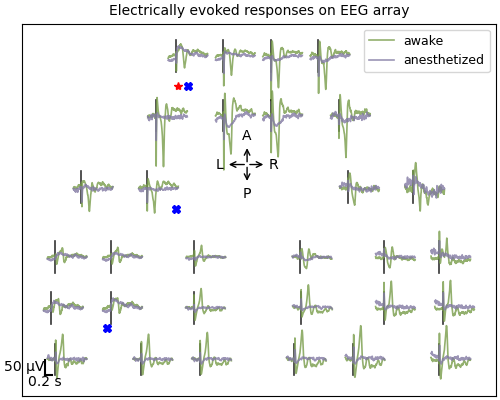

In [126]:
exmouse = '569069'
exgroup = 'MOs_deep'
plwin = [-0.2, 0.8]
xmult = 1.2
ymult = 150 # 250 for VEPs: 100

EEG_traces = multi_sub_dict[exgroup][exmouse]['EEG_traces']
NUM_TRIALS = min([EEG_traces[x][1].shape[2] for x in EEG_traces.keys()])

fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
for statei in test_states:
    timex = EEG_traces[statei][0]
    traces = np.mean(EEG_traces[statei][1][:, :, :NUM_TRIALS], axis=2)
    pinds = np.nonzero((timex >= plwin[0]) & (timex <= plwin[1]))[0]
    
    for chi in multi_sub_dict[exgroup][exmouse]['good_chs']:
        if chi == 0:
            llabel = statei
        else:
            llabel = None
        if statei == 'awake':
            ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
                     0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
                    [-50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
                     50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
                    color='k', linewidth=1.2, alpha=0.8, label=None)
        ax.plot(
            timex[pinds] + (EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
            traces[pinds, chi] + (EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
            color=state_colors[statei], linewidth=1.2, alpha=0.8, label=llabel
        )
        
        if chi == 0:
            mx = timex[0] + EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * 1.02
            my = EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

## Scale bar ##
x_len = .2 # x scale bar length in ms
y_len = 50 # y scale bar length in uV
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

## Add symbols for stim, NPXs, and bregma ##
ax.annotate(
    'A', xy=(0,0), xycoords='data', xytext=(0,70), textcoords='data',
    arrowprops=dict(arrowstyle='<-', lw=1), ha='center', va='bottom'
)
ax.annotate(
    'P', xy=(0,0), xycoords='data', xytext=(0,-70), textcoords='data',
    arrowprops=dict(arrowstyle='<-', lw=1), ha='center', va='top'
)
ax.annotate(
    'L', xy=(0,0), xycoords='data', xytext=(-0.8,0), textcoords='data',
    arrowprops=dict(arrowstyle='<-', lw=1), ha='left', va='center'
)
ax.annotate(
    'R', xy=(0,0), xycoords='data', xytext=(0.8,0), textcoords='data',
    arrowprops=dict(arrowstyle='<-', lw=1), ha='right', va='center'
)
ax.plot([-1.75], [250], marker='*', color='r') #, label='stim')
ax.plot([-1.5, -1.8, -3.55], [250, -140, -520], marker='X', color='b', linestyle='none')

ax.set_title('Electrically evoked responses on EEG array')
ax.legend(loc='upper right', prop={'size': 9})
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

## Save ##
figname = 'Figure1D_{}_{}_arrayERP_5x4.png'.format(exgroup, exmouse)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

### Plot PCI of all subjects (fig 1E)

all mice: n = 26, pval = 3.79e-11


<IPython.core.display.Javascript object>


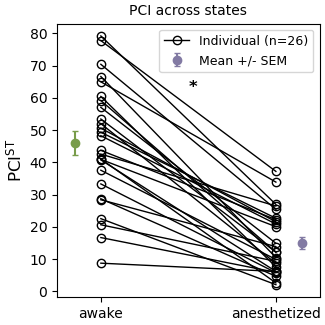

In [108]:
## Gather PCI values ##
allPCIvals = []
for group, group_subs in multi_sub_dict.items():
    gPCIvals = np.zeros((len(test_states), len(group_subs)), dtype=float)
    for ii, (mouse, gdata) in enumerate(group_subs.items()):
        for kk, statei in enumerate(test_states):
            gPCIvals[kk, ii] = gdata['PCI_output'][statei]['PCI']
    allPCIvals.append(gPCIvals)
allPCIvals = np.concatenate(allPCIvals, axis=1)

## Stats test ##
allpairt, allpairt_pval = stats.ttest_rel(allPCIvals[0,:], allPCIvals[1,:])
print('all mice: n = {:d}, pval = {:.2e}'.format(allPCIvals.shape[1], allpairt_pval))

## Plot it ##
fig, ax = plt.subplots(figsize=(3.25, 3.25), constrained_layout=True)
delta = 0.15

x = np.arange(allPCIvals.shape[0])
individs = ax.plot(x, allPCIvals, color='k', linewidth=1, marker='o', fillstyle='none')
deltax = np.array([-1, 1]) * delta
for jj in range(len(test_states)):
    mean_sem = ax.errorbar(
        x[jj] + deltax[jj], np.mean(allPCIvals, axis=1)[jj], yerr=stats.sem(allPCIvals, axis=1)[jj],
        color=state_colors[test_states[jj]], linestyle='none', marker='o', markersize=6,
    )
## annotate with asterisk ##
if allpairt_pval < 0.01:
    ax.annotate('*', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12, fontweight='bold')
    
ax.set_xticks(x)
ax.set_xticklabels(test_states) # (['aw', 'an'])
ax.set_xlim([-0.25, 1.25])
ax.set_ylabel('$\mathregular{PCI^{ST}}$', fontsize=12)
ax.set_title('PCI across states')

## Legend ##
ax.legend([individs[0], mean_sem], [('Individual (n={:d})'.format(allPCIvals.shape[1])), 'Mean +/- SEM'], prop={'size': 9})

## Save ##
figname = 'Figure1E_allmice_rest-iso_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

### Plot sliding window PCI of all subjects (fig 1F)

In [12]:
window_size = 0.1 # window size, s
slide_time = 0.02 # overlap of sliding windows
window_starts = np.arange(0, slide_time + 1.0, slide_time)
print(len(window_starts))

swinPCI_params = {
    'baseline_window': (-0.8, -0.001), # s before stim for baseline
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

51


In [20]:
sliding_PCI = {}
for group, group_subs in multi_sub_dict.items():
    print(group)
    sliding_PCI[group] = {}
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        sliding_PCI[group][mouse_num] = {}
        EEG_traces = mdata['EEG_traces']
        start = time.time()
        
        NUM_TRIALS = min([EEG_traces[x][1].shape[2] for x in EEG_traces.keys()])
        print('  Good channels: {:d}'.format(mdata['good_chs'].shape[0]))
        print('  Trials: {:d}'.format(NUM_TRIALS))
        
        if NUM_TRIALS < 30:
            print('Not enough trials, not computing PCI.')
            print('')
            continue
        
        for statei in EEG_traces.keys():
            state_traces = np.mean(EEG_traces[statei][1][:, :, :NUM_TRIALS], axis=2)
            
            ## Calculate PCIst for each window ##
            time_PCI = np.zeros_like(window_starts)
            for j, windowj in enumerate(window_starts):
                swinPCI_params['response_window'] = (windowj, windowj + window_size)
                time_PCI[j] = calc_PCIst(
                    state_traces[:, mdata['good_chs']].T, EEG_traces[statei][0], full_return=False, **swinPCI_params
                );
            sliding_PCI[group][mouse_num][statei] = time_PCI
        
        end = time.time()
        print(' Time: {:.2f} min\n'.format((end-start)/60))

MOs_superficial
 521885
  Good channels: 17
  Trials: 47
 Time: 1311.34 s

 521886
  Good channels: 20
  Trials: 87
 Time: 867.92 s

 521887
  Good channels: 21
  Trials: 148
 Time: 1371.71 s

 543393
  Good channels: 24
  Trials: 246
 Time: 873.75 s

 543394
  Good channels: 21
  Trials: 192
 Time: 398.60 s

 546655
  Good channels: 22
  Trials: 40
 Time: 656.69 s

 575102
  Good channels: 26
  Trials: 83
 Time: 1270.13 s

 571619
  Good channels: 25
  Trials: 89
 Time: 788.92 s

MOs_deep
 551399
  Good channels: 22
  Trials: 108
 Time: 1075.55 s

 551397
  Good channels: 27
  Trials: 96
 Time: 1196.58 s

 569062
  Good channels: 28
  Trials: 102
 Time: 1034.76 s

 569068
  Good channels: 30
  Trials: 99
 Time: 792.35 s

 569069
  Good channels: 30
  Trials: 82
 Time: 1061.20 s

 569064
  Good channels: 30
  Trials: 116
 Time: 1132.22 s

 569073
  Good channels: 27
  Trials: 86
 Time: 969.14 s

 571619
  Good channels: 25
  Trials: 97
 Time: 1213.84 s

 569070
  Good channels: 26
  Tr

Plot the figure...need to fix below

<IPython.core.display.Javascript object>


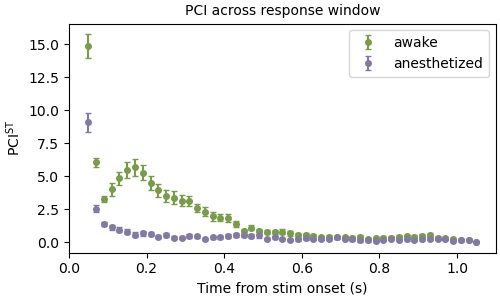

In [44]:
PCI_time = {}
for statei in test_states:
    state_matrix = []
    for group, group_subs in sliding_PCI.items():
        for mouse_num, PCIdata in group_subs.items():
            state_matrix.append(PCIdata[statei])
    PCI_time[statei] = np.stack(state_matrix, axis=1)
    
fig, ax = plt.subplots(figsize=(5,3), constrained_layout=True)
timex = window_starts + (window_size / 2)
for statei in PCI_time.keys():
    mean_PCI = np.mean(PCI_time[statei], axis=1)
    sem_PCI = np.std(PCI_time[statei], axis=1) / np.sqrt(PCI_time[statei].shape[1])
    ax.errorbar(
        timex, mean_PCI, yerr=sem_PCI, color=state_colors[statei], linestyle='none', marker='o', markersize=4, label=statei
    )
    
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('$\mathregular{PCI^{ST}}$')
ax.set_title('PCI across response window')
ax.legend()

## Save ##
figname = 'Figure1F_allmice_slidingPCI_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

# Plot figure 2

In [134]:
## Choose example mice, CK suggests choosing same mouse for superficial and deep ##
example_mice = {
    'MOs_superficial': '571619',
    'MOs_deep': '571619',
    'SSp_superficial': '571620', # '571620'
    'SSp_deep': '571620',
}

group_titles = {
    'MOs_superficial': 'Superficial MOs',
    'MOs_deep': 'Deep MOs',
    'SSp_superficial': 'Superficial SSp',
    'SSp_deep': 'Deep SSp',
}

<IPython.core.display.Javascript object>


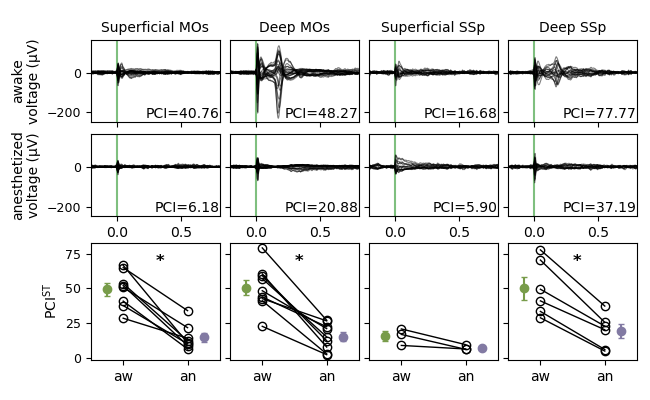

MOs_superficial: n = 8, pval = 9.84e-05
MOs_deep: n = 9, pval = 7.44e-05
SSp_superficial: n = 3, pval = 1.01e-01
SSp_deep: n = 6, pval = 5.59e-04


In [138]:
plwin = [-0.2, 0.8]
# volt_lim = [-250, 200]
delta = 0.25
plt.rc('ytick', labelsize=9)

fig = plt.figure(figsize=(6.5,4))
gs = fig.add_gridspec(
    ncols=1, nrows=2, height_ratios=[3,2], left=0.14, right=0.98, top=0.9, bottom=0.1, hspace=0.18
)
EEGaxs = gs[0].subgridspec(
    ncols=len(multi_sub_dict), nrows=len(EEG_traces), hspace=0.15, wspace=0.08).subplots(sharex=True, sharey=True)
PCIax = gs[1].subgridspec(ncols=len(multi_sub_dict), nrows=1, wspace=0.08).subplots(sharex=True, sharey=True)

for coli, (group, group_subs) in enumerate(multi_sub_dict.items()):
    ## Plot EEG butterfly plots ##
    EEG_traces = group_subs[example_mice[group]]['EEG_traces']
    GOOD_CHS = group_subs[example_mice[group]]['good_chs']
    NUM_TRIALS = min([EEG_traces[x][1].shape[2] for x in EEG_traces.keys()])
    for rowi, statei in enumerate(EEG_traces.keys()):
        timex = EEG_traces[statei][0]
        traces = np.mean(EEG_traces[statei][1][:, :, :NUM_TRIALS], axis=2)
        pinds = np.nonzero((timex >= plwin[0]) & (timex <= plwin[1]))[0]
        
        EEGaxs[rowi, coli].axvline(0, color='g', alpha=0.5)
        EEGaxs[rowi, coli].plot(timex[pinds], traces[pinds, :][:, GOOD_CHS], 'k', linewidth=0.8, alpha=0.5)
        EEGaxs[rowi, coli].annotate(
            'PCI={:.2f}'.format(group_subs[example_mice[group]]['PCI_output'][statei]['PCI']),
            xy=(1, 0.01), xycoords='axes fraction', fontsize=10, ha='right', va='bottom'
        )
        if coli == 0:
            EEGaxs[rowi, coli].set_ylabel('{}\nvoltage (\u03bcV)'.format(statei))
#         else:
#             EEGaxs[rowi, coli].set_yticklabels([])
#     EEGaxs[rowi].set_ylim(volt_lim)
    EEGaxs[0, coli].set_title(group_titles[group])
    
    ## Plot PCI values ##
    PCIvals = np.zeros((len(test_states), len(group_subs)), dtype=float)
    for ii, (mouse, gdata) in enumerate(group_subs.items()):
        for kk, statei in enumerate(test_states):
            PCIvals[kk, ii] = gdata['PCI_output'][statei]['PCI']
    ## Stats test ##
    pairt, pairt_pval = stats.ttest_rel(PCIvals[0,:], PCIvals[1,:])
    print('{}: n = {:d}, pval = {:.2e}'.format(group, PCIvals.shape[1], pairt_pval))
    x = np.arange(PCIvals.shape[0])
    individs = PCIax[coli].plot(x, PCIvals, color='k', linewidth=1, marker='o', fillstyle='none')
    deltax = np.array([-1, 1]) * delta
    for jj in range(len(test_states)):
        mean_sem = PCIax[coli].errorbar(
            x[jj] + deltax[jj], np.mean(PCIvals, axis=1)[jj], yerr=stats.sem(PCIvals, axis=1)[jj],
            color=state_colors[test_states[jj]], linestyle='none', marker='o' #, markersize=8,
        )
    ## annotate with asterisk ##
    if pairt_pval < 0.01:
        PCIax[coli].annotate('*', xy=(0.5, 0.8), xycoords='axes fraction', fontsize=12, fontweight='bold')
    PCIax[coli].set_xticks(x)
    PCIax[coli].set_xticklabels(['aw', 'an'])
    if coli == 0:
        PCIax[coli].set_xlim([-0.5, 1.5])
        PCIax[coli].set_ylabel('$\mathregular{PCI^{ST}}$')
        
EEGaxs[0, 0].set_xlim(plwin)

## Save ##
figname = 'Figure2_allstimlocs_rest-iso_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)